In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import datetime
import time
import matplotlib as mpl
import re
import xlrd
from datetime import date
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample
from math import log10, floor
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, littleQA, totalUP
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame
from src.utility.GeneralUtility import date_range, random_string, timer
from src.alert_analysis.SpoofingAnalysis import get_place_rank_of_order
from src.data_models.DailyBestPricesSplitByAccountDataModel import DailyBestPricesSplitByAccountDataModel

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#### (0) SET parameters of analysis

In [2]:
evaluation_date = datetime.date(2019,7,1)
start_date = datetime.date(2019,7,1)
period = (evaluation_date - start_date).days + 1
datelist = pd.date_range(start_date, periods=period).astype(str).str.replace('-','').tolist()
instrument = 'BTCUSD'

#### >>> IMPORT raw source data

In [119]:
# base_data_set = SmartsDataModel().initialize(evaluation_date=evaluation_date, start_date = start_date, other_condition="symbol = '{}'".format(instrument)).evaluate()
# base_data_set['date_time'] = pd.to_datetime(base_data_set['event_date'].astype('str') + ' ' + base_data_set['event_time'].astype(str)) + base_data_set['event_millis']
# base_data_set.to_pickle('~/Documents/base_data_set.pkl')
# base_data_set = pd.read_pickle('~/Documents/base_data_set.pkl')

#### >>> IMPORT ranked data

In [4]:
# for i in datelist:
#     print(i)
#     best_prices = DailyBestPricesSplitByAccountDataModel().initialize(evaluation_date=i, other_condition="symbol = '{}'".format(instrument)).evaluate()
#     best_prices.to_pickle('~/Documents/i_rankeddata.pkl')
#     best_prices = pd.read_pickle('~/Documents/i_rankeddata.pkl')

#### >>> JOIN together

In [5]:
# result = base_data_set.merge(best_prices.drop(columns=['event_date', 'symbol', 'side', 'date_time']), how='left', on=['account_id', 'event_id', 'event_type'])

#### >>> COMPUTE rank

In [6]:
# abc = datetime.datetime.now()
# test = get_place_rank_of_order(result,10)
# print(datetime.datetime.now()- abc)

#### (1) START HERE by reading in saved ranked data

In [124]:
# test.to_pickle('~/Documents/ranked.pkl')
test0 = pd.read_pickle('~/Documents/ranked.pkl')

In [125]:
test0.groupby('side').count()['account_id']

side
buy     842616
sell    863819
Name: account_id, dtype: int64

In [127]:
test = test0.loc[test0['side'] == 'buy']
test.shape

(842616, 68)

#### (2) DROP unnecessary columns

In [8]:
cols = ['best_price_' + str(s+1) for s in range(0,10)] + ['best_account_volume_' + str(s+1) for s in range(0,10)]
test2 = test.drop(columns=(cols + [s + '_other_side' for s in cols]))

#### (3) FIX rank formats

In [128]:
def fix(rank):
    if rank == '':
        return(np.NaN)
    elif rank == '> 10': 
        return(11) 
    elif len(rank) == 0: return(np.NaN) 
    else: return(rank)

test2['place_rank_int'] = test2['place_rank'].str.replace('Rank ','').apply(fix).astype(float)
test2['fill_rank_int'] = test2['fill_rank'].str.replace('Rank ','').apply(fix).astype(float)
test2['cancel_rank_int'] = test2['cancel_rank'].str.replace('Rank ','').apply(fix).astype(float)

#### (4) VERIFY that ranks are the same over side, order_id and event_type ['side' was already filtered for]

In [129]:
# test2.groupby(['place_rank_int', 'place_rank']).count()['account_id']
# test2.groupby(['fill_rank_int', 'fill_rank']).count()['account_id']
# test2.groupby(['cancel_rank_int', 'cancel_rank']).count()['account_id']

In [150]:
test2gb = test2.groupby(['account_id','order_id'])

In [151]:
test2gb_place = pd.concat([test2gb['place_rank_int'].min(),test2gb['place_rank_int'].max()], axis=1)
test2gb_place.columns =['placerank_min','placerank_max']
test2gb_place.loc[test2gb_place['placerank_min'] != test2gb_place['placerank_max']].count()

placerank_min    0
placerank_max    0
dtype: int64

In [152]:
test2gb_fill = pd.concat([test2gb['fill_rank_int'].min(),test2gb['fill_rank_int'].max()], axis=1)
test2gb_fill.columns =['fillrank_min','fillrank_max']
test2gb_fill.loc[(test2gb_fill['fillrank_min'] != test2gb_fill['fillrank_max']) & (test2gb_fill['fillrank_min'] > 0)].count()

fillrank_min    1134
fillrank_max    1134
dtype: int64

In [153]:
test2gb_cancel = pd.concat([test2gb['cancel_rank_int'].min(),test2gb['cancel_rank_int'].max()], axis=1)
test2gb_cancel.columns =['cancelrank_min','cancelrank_max']
test2gb_cancel.loc[(test2gb_cancel['cancelrank_min'] != test2gb_cancel['cancelrank_max']) & (test2gb_cancel['cancelrank_min'] > 0)].count()

cancelrank_min    0
cancelrank_max    0
dtype: int64

#### (5) MERGE place, fill, and cancel ranks by order_id

In [154]:
combo = pd.concat([test2gb['place_rank_int'].mean(),test2gb_fill, test2gb['cancel_rank_int'].mean()], axis=1)
(~combo.isna()).sum()

place_rank_int     851955
fillrank_min        17081
fillrank_max        17081
cancel_rank_int    831209
dtype: int64

#### (6) COMPUTE rank change after fill/cancel

In [176]:
combo['change_fill'] = combo['fillrank_min'] - combo['place_rank_int']
combo['change_cancel'] = combo['cancel_rank_int'] - combo['place_rank_int']
combogb = combo.reset_index().groupby('account_id')[['change_fill', 'change_cancel']]
combo1 = pd.concat([round(combogb.mean().add_suffix('_mean'),1), combogb.count().add_suffix('_count')], axis=1).sort_values('change_cancel_count', ascending=False)

#### (7) TRUNCATE zeros to see meaningful changes in rank

In [184]:
combo2_fill = combo1.loc[combo1['change_fill_mean'] != 0,'change_fill_mean']
combo2_cancel = combo1.loc[combo1['change_cancel_mean'] != 0,'change_cancel_mean']

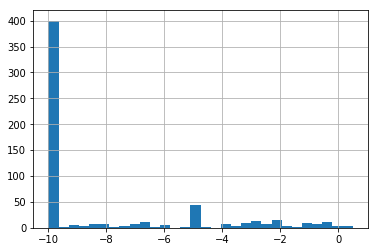

In [185]:
combo2_fill.hist(bins=30)

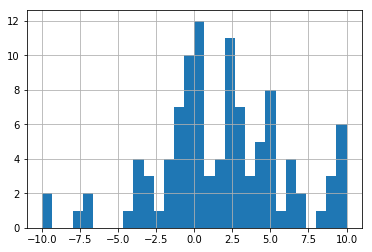

In [186]:
combo2_cancel.hist(bins=30)

#### (8) IDENTIFY accounts most likely to run from spread

In [193]:
combo1.sort_values('change_cancel_mean').head(10)

,change_fill_mean,change_cancel_mean,change_fill_count,change_cancel_count
account_id,,,,
67352,0.0,-10.0,1,1
556574,0.0,-10.0,4,1
996225,-9.0,-8.0,1,1
816693,-10.0,-7.0,3,1
207472,0.0,-7.0,1,1
521234,-10.0,-4.3,3,3
225613,-1.5,-4.0,21,1
350642,-2.0,-4.0,5,2
253956,NaN,-3.5,0,2


In [194]:
combo1.loc[(combo1['change_cancel_mean'] < 0) & (combo1['change_cancel_count'] > 100)]

,change_fill_mean,change_cancel_mean,change_fill_count,change_cancel_count
account_id,,,,
444259,-3.6,-0.1,698,72661
202474,-8.9,-0.5,11,10238
224099,-10.0,-0.1,3,5693
898579,-1.9,-1.1,214,2383
399148,NaN,-0.1,0,290
31800,0.0,-0.1,2,220
